In [1]:
import sys
sys.path.append('/home/berni/education/counterfactuals/src')


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from explainers_lib.explainers.wachter import WachterExplainer
from explainers_lib.explainers.growing_spheres import GrowingSpheresExplainer
from explainers_lib.explainers.celery_explainer import ActionableRecourseExplainer
from explainers_lib.explainers.celery_explainer import FaceExplainer
from explainers_lib.explainers.celery_explainer import DiceExplainer
from explainers_lib.explainers.celery_explainer import AlibiCFProto
from explainers_lib.explainers.celery_explainer import AlibiCFRL
from explainers_lib.aggregators import Pareto
from explainers_lib.datasets import Dataset
from explainers_lib.ensemble import Ensemble
from explainers_lib.model import TorchModel
import shap


In [3]:
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
df = pd.read_csv(url)
df = df.drop(['Name'], axis=1)
categorical_features = ['Sex', 'Pclass']
numerical_features = ['Age', 'Fare', 'Parents/Children Aboard', 'Siblings/Spouses Aboard']
target = 'Survived'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer

class InverseColumnTransformer(ColumnTransformer):
    """
    A custom ColumnTransformer that adds an 'inverse_transform' method.

    IMPORTANT: This implementation is tightly coupled to the *specific*
    pipelines provided in the user's question. It assumes:
    1. A 'num' transformer pipeline with a 'scaler' step.
    2. A 'cat' transformer pipeline with an 'onehot' step.
    3. 'remainder' is set to 'passthrough'.
    
    It "inverts" the data by reversing only the reversible steps
    (scaler, onehot) while ignoring the non-reversible SimpleImputers.
    """
    
    # Override fit to store original DataFrame columns
    def fit(self, X, y=None):
        """
        Fits the transformer and stores the original column names
        and order if X is a pandas DataFrame.
        """
        if isinstance(X, pd.DataFrame):
            self.original_columns_ = list(X.columns)
        else:
            # Fallback for numpy arrays
            self.original_columns_ = list(range(X.shape[1]))
            
        # --- BUG FIX 1: This line is ESSENTIAL ---
        # It calls the parent's fit method, which fits all the
        # transformers (pipelines) and populates self.transformers_
        # return super().fit(X, y)

    def inverse_transform(self, X_transformed):
        """
        Reverses the scaling and one-hot encoding steps to return
        a NumPy array as close to the original as possible.
        
        Imputed values are NOT reversed.
        """
        
        # --- Improved Input Validation ---
        # Ensure X_transformed is a numpy array
        if not isinstance(X_transformed, np.ndarray):
            X_transformed = np.array(X_transformed)

        # Handle 1D array (e.g., a single prediction)
        if X_transformed.ndim == 1:
            X_transformed = X_transformed.reshape(1, -1)
            
        # Now, ensure it's 2D
        if X_transformed.ndim != 2:
            raise ValueError(f"X_transformed must be a 1D or 2D array, but got shape {X_transformed.shape}")
            
        if not hasattr(self, 'original_columns_'):
            raise ValueError("The 'fit' method must be called before 'inverse_transform'.")

        inverted_parts = {}
        current_col_idx = 0

        # Iterate over the fitted transformers
        for name, transformer, original_cols in self.transformers_:
            
            if transformer == 'drop':
                continue # Dropped columns are ignored

            elif transformer == 'passthrough':
                # This handles the 'remainder'
                n_features = len(original_cols)
                if n_features == 0:
                    continue
                
                # Slicing the numpy array
                part_data = X_transformed[:, current_col_idx : current_col_idx + n_features]
                # Storing as a DataFrame for easy combining later
                inverted_parts[name] = pd.DataFrame(part_data, columns=original_cols)
                current_col_idx += n_features

            else:
                # This is a Pipeline
                if name == 'num':
                    # --- Specific to the 'num' pipeline ---
                    try:
                        scaler = transformer.named_steps['scaler']
                    except KeyError:
                        raise ValueError("The 'num' pipeline must have a step named 'scaler'.")
                        
                    n_features = len(original_cols)
                    part_data = X_transformed[:, current_col_idx : current_col_idx + n_features]
                    
                    # Invert only the 'scaler' step
                    inverted_data = scaler.inverse_transform(part_data)
                    inverted_parts[name] = pd.DataFrame(inverted_data, columns=original_cols)
                    current_col_idx += n_features

                elif name == 'cat':
                    # --- Specific to the 'cat' pipeline ---
                    try:
                        onehot = transformer.named_steps['onehot']
                    except KeyError:
                        raise ValueError("The 'cat' pipeline must have a step named 'onehot'.")
                        
                    # Get the *output* feature count from the one-hot encoder
                    try:
                        n_output_features = len(onehot.get_feature_names_out(original_cols))
                    except Exception:
                        # Fallback if get_feature_names_out fails
                        n_output_features = sum(len(c) for c in onehot.categories_)
                        
                    part_data = X_transformed[:, current_col_idx : current_col_idx + n_output_features]
                    
                    # Invert only the 'onehot' step
                    inverted_data = onehot.inverse_transform(part_data)
                    inverted_parts[name] = pd.DataFrame(inverted_data, columns=original_cols)
                    current_col_idx += n_output_features
                
                else:
                    # Handle other pipelines
                    raise ValueError(f"Unknown transformer '{name}' is not supported for inversion.")

        # Concatenate all inverted DataFrames
        try:
            df_inverted = pd.concat(inverted_parts.values(), axis=1)
        except ValueError as e:
            raise RuntimeError(f"Failed to concatenate inverted parts. Check for index mismatches. Error: {e}")

        # Re-order to match the original DataFrame's column order
        df_inverted_original_order = df_inverted[self.original_columns_]
        
        return df_inverted_original_order.values


In [5]:
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = InverseColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),('cat', categorical_transformer, categorical_features)], remainder='passthrough')


In [13]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
preprocessor.fit(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

X_train_tensor = torch.FloatTensor(X_test_processed)

data = Dataset(X_test_processed, y_test.values, feature_names, list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)), numerical_features, [], [])
print(feature_names)
pd.DataFrame(X_test_processed).head()


['Age', 'Fare', 'Parents/Children Aboard', 'Siblings/Spouses Aboard', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3']


,0,1,2,3,4,5,6,7,8
0,1.254300,-0.057632,-0.475009,-0.470388,0.0,1.0,1.0,0.0,0.0
1,-0.307067,0.151902,1.992254,0.402662,0.0,1.0,0.0,1.0,0.0
2,2.815666,-0.360229,-0.475009,-0.470388,0.0,1.0,0.0,0.0,1.0
3,1.893041,0.036930,-0.475009,-0.470388,0.0,1.0,1.0,0.0,0.0
4,1.964012,-0.400890,-0.475009,-0.470388,0.0,1.0,0.0,1.0,0.0


In [7]:
# Wrap the NumPy array in a pd.DataFrame to use .head()
inverted_data = preprocessor.inverse_transform(X_test_processed)
pd.DataFrame(inverted_data).head()


,0,1,2,3,4,5
0,1,male,47.0,0.0,0.0,30.5
1,2,male,25.0,1.0,2.0,41.5792
2,3,male,69.0,0.0,0.0,14.5
3,1,male,56.0,0.0,0.0,35.5
4,2,male,57.0,0.0,0.0,12.35


In [8]:
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x


In [9]:
input_dim = X_train_processed.shape[1]
with open("experiments/models/titanic_classifier.pt", "rb") as f:
    model_data = f.read()

model = TorchModel.deserialize(model_data)
model, input_dim


(<explainers_lib.model.TorchModel at 0x7f80b98a3a10>, 9)

In [10]:
ensemble = Ensemble(model, [WachterExplainer(), GrowingSpheresExplainer(), 
                            ActionableRecourseExplainer(), #DiceExplainer(), 
                            FaceExplainer(), AlibiCFProto(), AlibiCFRL()], Pareto())
ensemble.fit(data)
cfs = ensemble.explain(data[:5], pretty_print=True, pretty_print_postprocess=preprocessor.inverse_transform, feature_names=preprocessor.original_columns_)
cfs


2instance [00:00,  6.76instance/s]/home/berni/education/counterfactuals/src/explainers_lib/explainers/wachter.py:129: UserWarning: Maximum number of function evaluations has been exceeded.
  warnings.warn(res["message"])
5instance [00:00,  6.38instance/s]
5instance [00:01,  2.62instance/s]


┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Pclass ┃    Sex ┃     Age ┃ Siblings/Spouses Aboard ┃ Parents/Children Aboard ┃    Fare ┃ target ┃ source       ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1.0000 │   male │ 47.0000 │                  0.0000 │                  0.0000 │ 30.5000 │      0 │ original     │
│        │        │         │                         │                         │         │        │ data         │
│ 1.0000 │ female │ 47.0000 │                  0.0000 │                  0.0000 │ 30.5000 │      1 │ actionable_… │
│    N/A │    N/A │     N/A │                     N/A │                     N/A │     N/A │    N/A │ cfproto()    │
│ 1.0000 │   male │ 33.0011 │                  0.7272 │                  0.6434 │ 41.1586 │      0 │ cfrl(latent… │
│        │        │         │                         │                         │         │        │ coeff_spars… │
│        │        │         │                         │                         │         │        │ coeff_consi… │
│        │        │         │                         │                         │         │        │ train_steps… │
│        │        │         │                         │                         │         │        │ batch_size=… │
│ 2.0000 │ female │ 30.0000 │                  0.0000 │                  0.0000 │ 13.0000 │      1 │ face_explai… │
│        │        │         │                         │                         │         │        │ fraction=0.… │
│        │        │         │                         │                         │         │        │ n_neighbors… │
│    N/A │    N/A │     N/A │                     N/A │                     N/A │     N/A │    N/A │ growing_sph… │
│        │        │         │                         │                         │         │        │ max_radius=… │
│        │        │         │                         │                         │         │        │ num_samples… │
│    N/A │    N/A │     N/A │                     N/A │                     N/A │     N/A │    N/A │ wachter(lam… │
│        │        │         │                         │                         │         │        │ random_seed… │
├────────┼────────┼─────────┼─────────────────────────┼─────────────────────────┼─────────┼────────┼──────────────┤
│ 2.0000 │   male │ 57.0000 │                  0.0000 │                  0.0000 │ 12.3500 │      0 │ original     │
│        │        │         │                         │                         │         │        │ data         │
│ 1.0000 │ female │ 57.0000 │                  0.0000 │                  0.0000 │ 12.3500 │      1 │ actionable_… │
│    N/A │    N/A │     N/A │                     N/A │                     N/A │     N/A │    N/A │ cfproto()    │
│    N/A │    N/A │     N/A │                     N/A │                     N/A │     N/A │    N/A │ cfrl(latent… │
│        │        │         │                         │                         │         │        │ coeff_spars… │
│        │        │         │                         │                         │         │        │ coeff_consi… │
│        │        │         │                         │                         │         │        │ train_steps… │
│        │        │         │                         │                         │         │        │ batch_size=… │
│ 2.0000 │ female │ 30.0000 │                  0.0000 │                  0.0000 │ 13.0000 │      1 │ face_explai… │
│        │        │         │                         │                         │         │        │ fraction=0.… │
│        │        │         │                         │                         │         │        │ n_neighbors… │
│    N/A │    N/A │     N/A │                     N/A │                     N/A │     N/A │    N/A │ growing_sph… │
│        │        │         │                         │ 

[Counterfactual(original_data=array([ 1.25429964, -0.05763158, -0.47500894, -0.47038771,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ]), data=array([ 1.25429964, -0.05763158, -0.47500894, -0.47038771,  1.        ,
         1.        ,  1.        ,  0.        ,  0.        ]), original_class=np.int64(0), target_class=np.int64(1), explainer='actionable_recourse(flip_size=1000)'),
 Counterfactual(original_data=array([ 1.25429964, -0.05763158, -0.47500894, -0.47038771,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ]), data=array([ 0.04778895, -0.38859731, -0.47500894, -0.47038771,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ]), original_class=np.int64(0), target_class=1, explainer='face_explainer(mode=knn, fraction=0.05, n_neighbors=50)'),
 Counterfactual(original_data=array([ 1.25429964, -0.05763158, -0.47500894, -0.47038771,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ]), data=array([

In [ ]:
cfs


[Counterfactual(original_data=array([ 1.25429964, -0.05763158, -0.47500894, -0.47038771,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ]), data=array([ 1.25429964, -0.05763158, -0.47500894, -0.47038771,  1.        ,
         1.        ,  1.        ,  0.        ,  0.        ]), original_class=np.int64(0), target_class=np.int64(1), explainer='actionable_recourse(flip_size=1000)'),
 Counterfactual(original_data=array([ 1.25429964, -0.05763158, -0.47500894, -0.47038771,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ]), data=array([-0.80386564,  3.66856977, -0.47500894,  0.40266173,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ]), original_class=np.int64(0), target_class=1, explainer='face_explainer(mode=knn, fraction=0.05, n_neighbors=50)'),
 Counterfactual(original_data=array([ 1.89304058,  0.03693006, -0.47500894, -0.47038771,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ]), data=array([

In [11]:
background_summary = shap.kmeans(X_train_processed, 10)

def predict_class_0(x):
    return model.predict_proba(x)[:, 0]
def predict_class_1(x):
    return model.predict_proba(x)[:, 1]

explainers = [
    shap.KernelExplainer(predict_class_0, background_summary, link="logit"),
    shap.KernelExplainer(predict_class_1, background_summary, link="logit")
]


  0%|          | 0/1 [00:00<?, ?it/s]

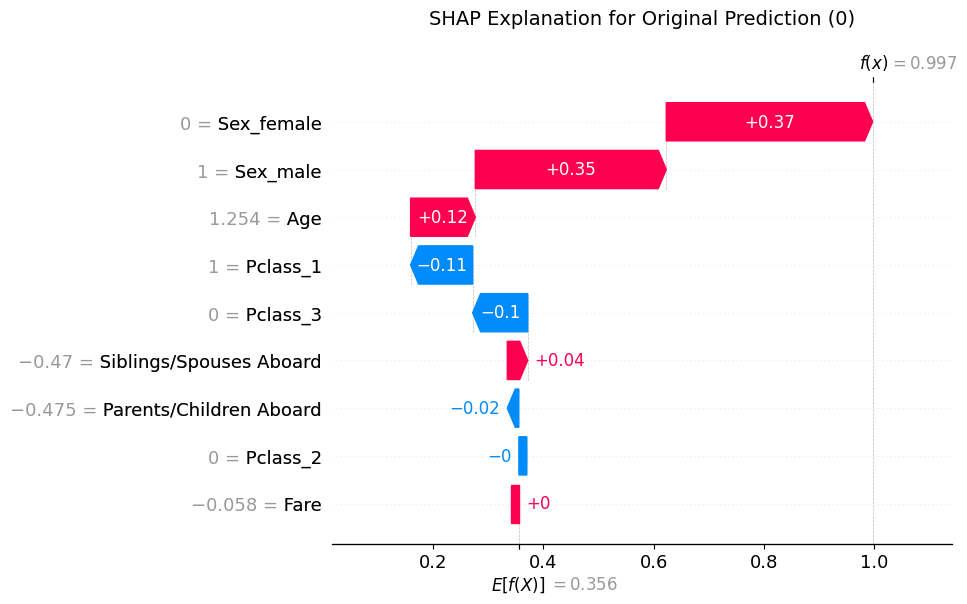

  0%|          | 0/1 [00:00<?, ?it/s]

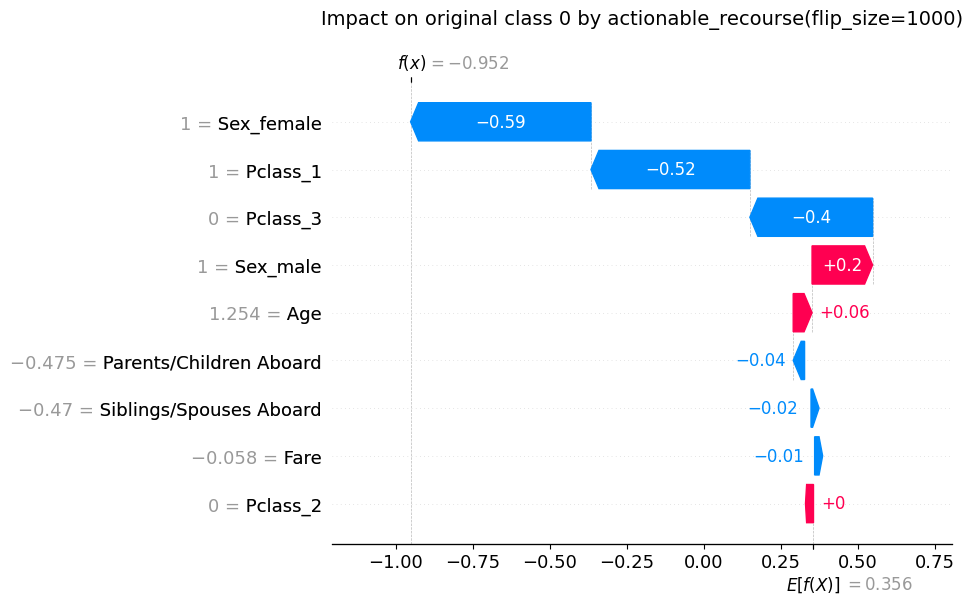

  0%|          | 0/1 [00:00<?, ?it/s]

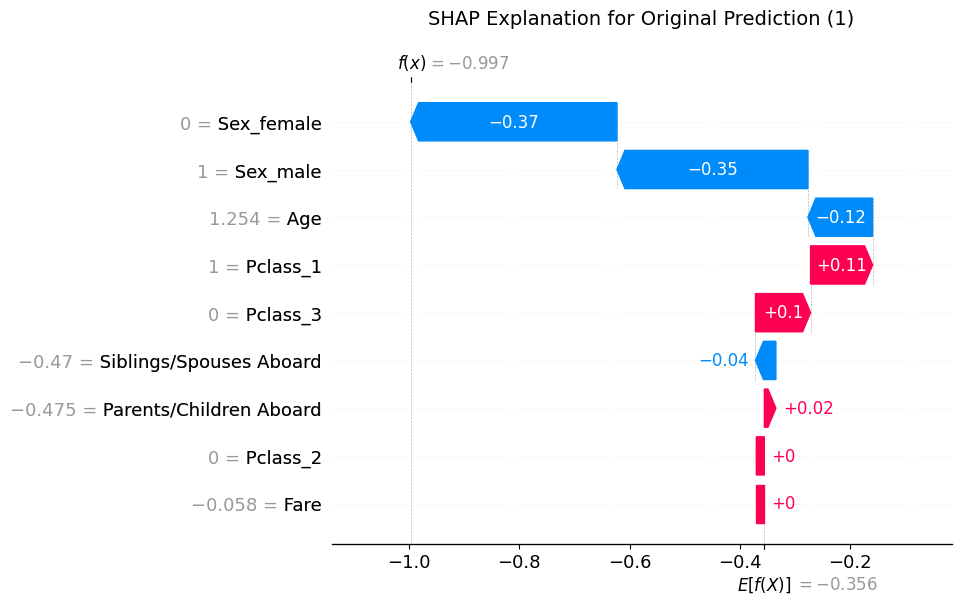

  0%|          | 0/1 [00:00<?, ?it/s]

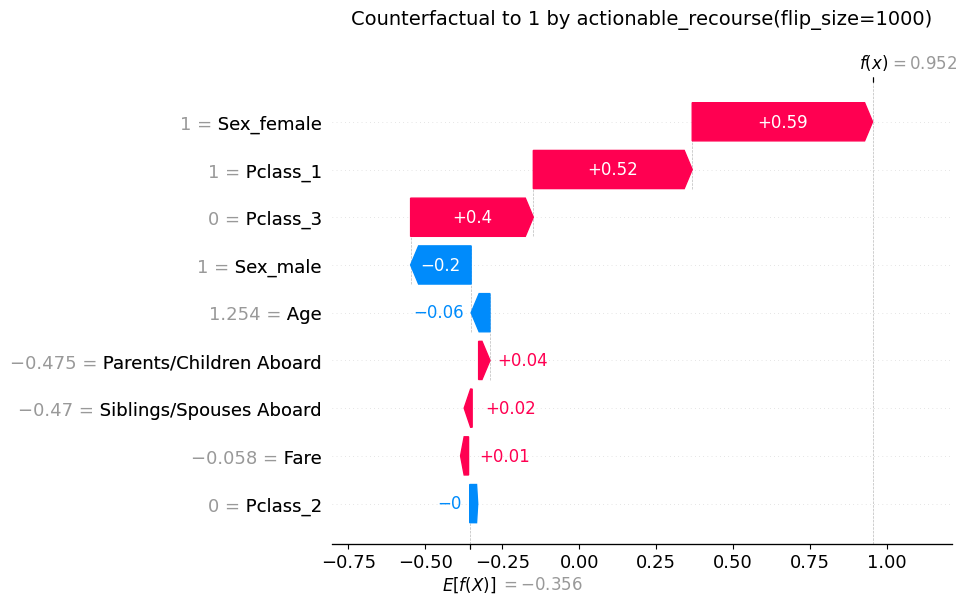

  0%|          | 0/1 [00:00<?, ?it/s]

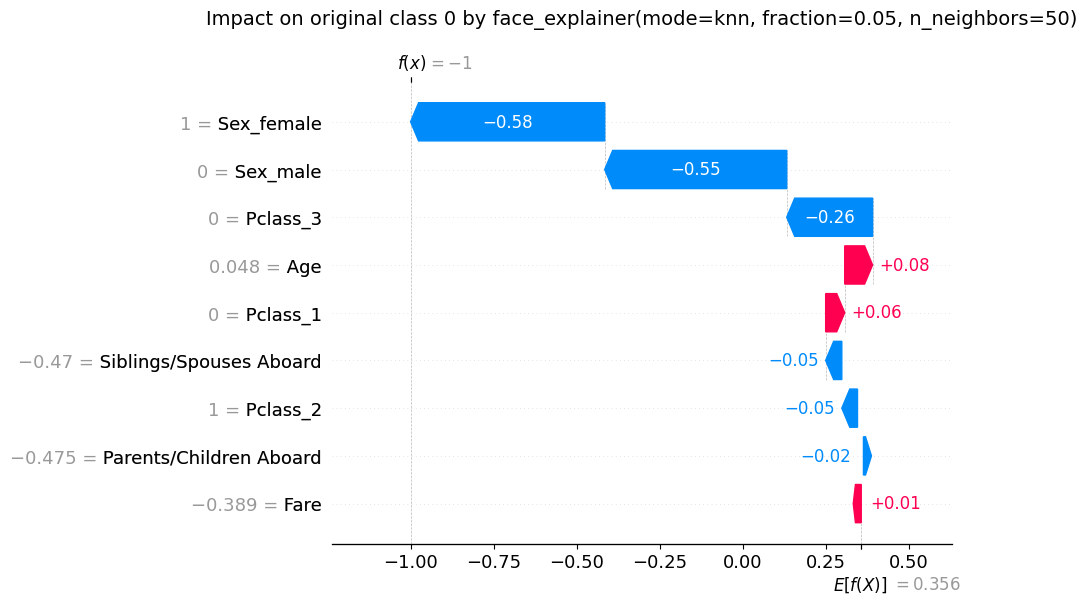

  0%|          | 0/1 [00:00<?, ?it/s]

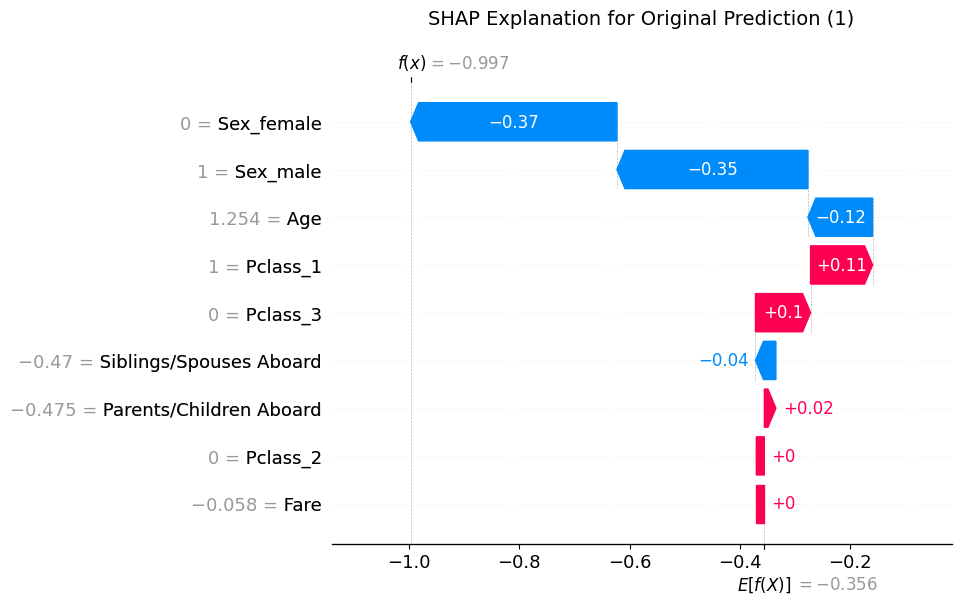

  0%|          | 0/1 [00:00<?, ?it/s]

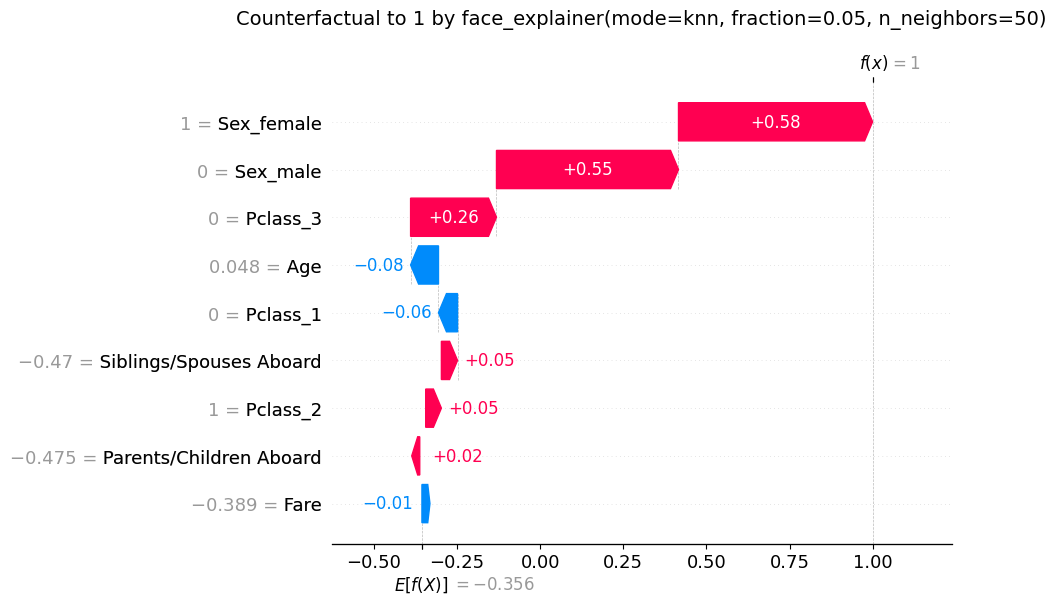

  0%|          | 0/1 [00:00<?, ?it/s]

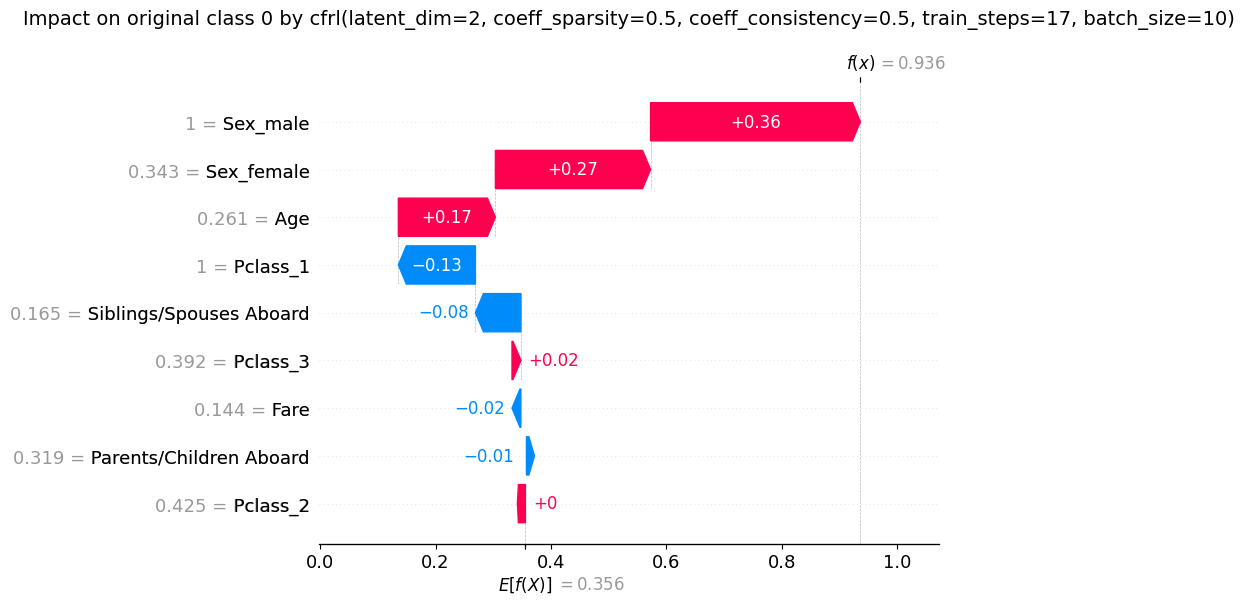

  0%|          | 0/1 [00:00<?, ?it/s]

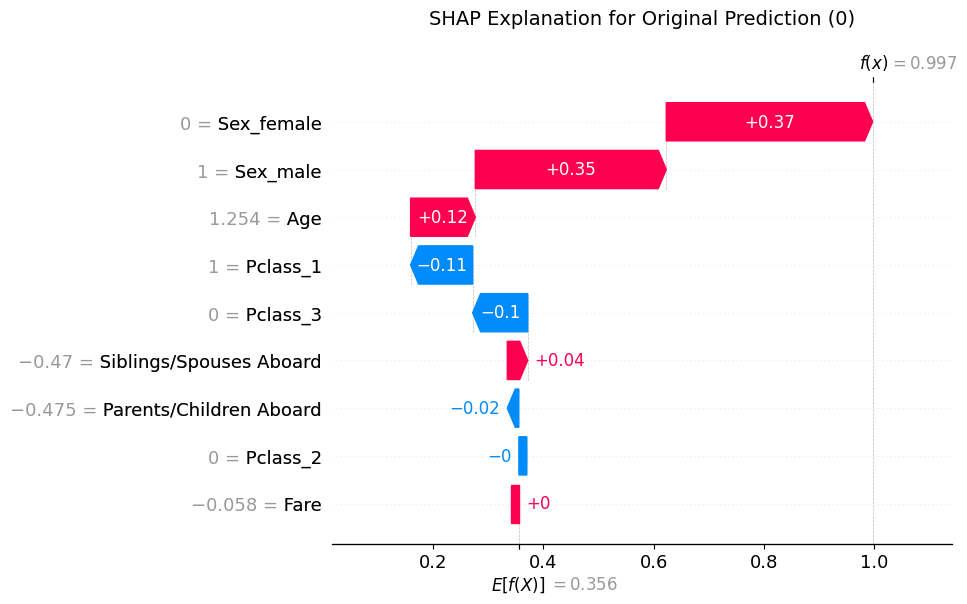

  0%|          | 0/1 [00:00<?, ?it/s]

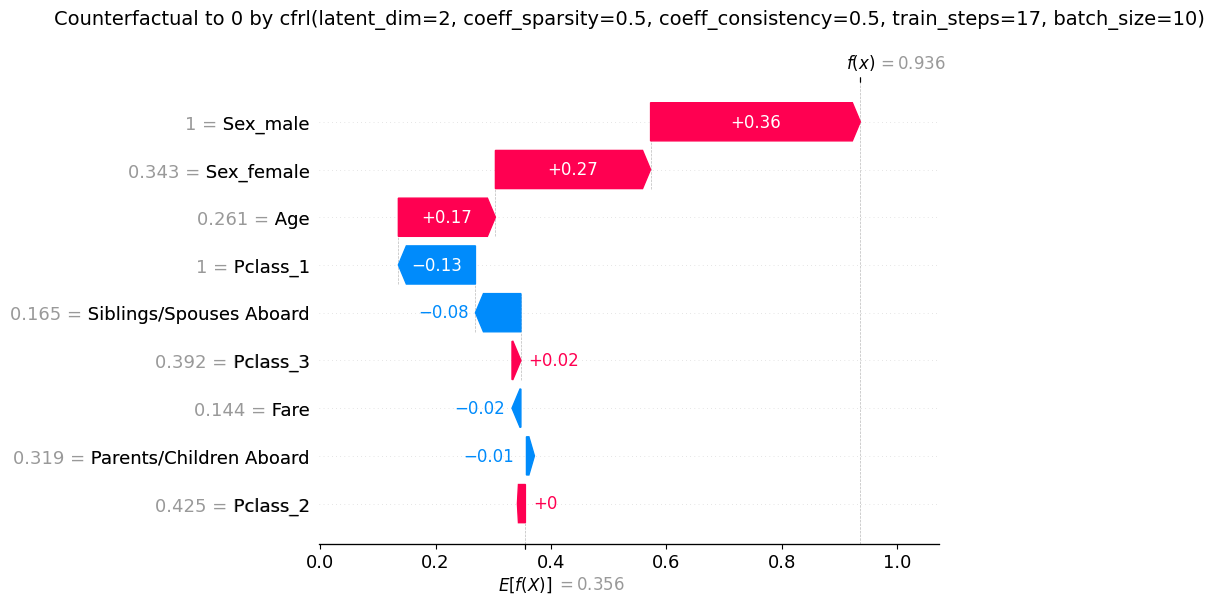

  0%|          | 0/1 [00:00<?, ?it/s]

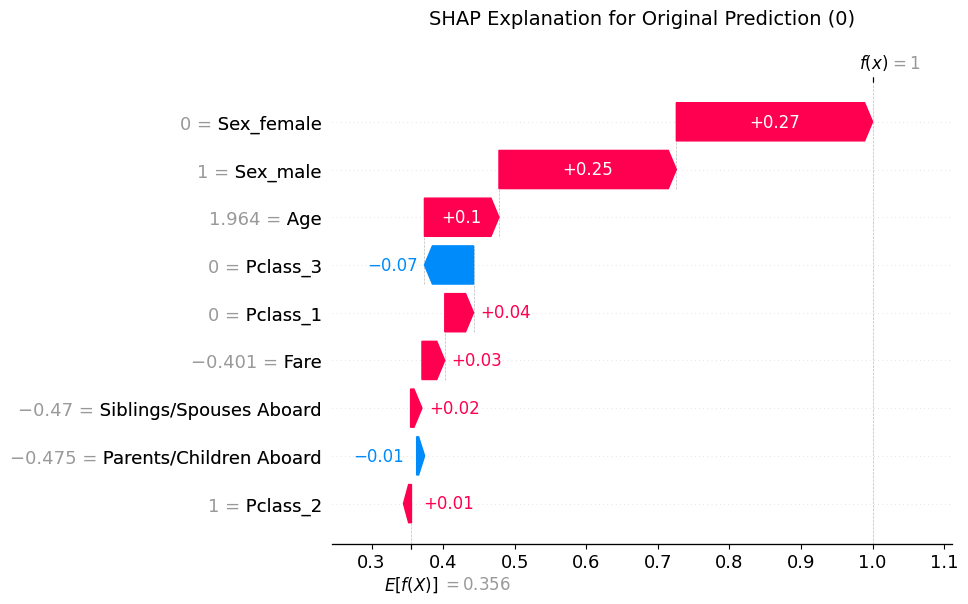

  0%|          | 0/1 [00:00<?, ?it/s]

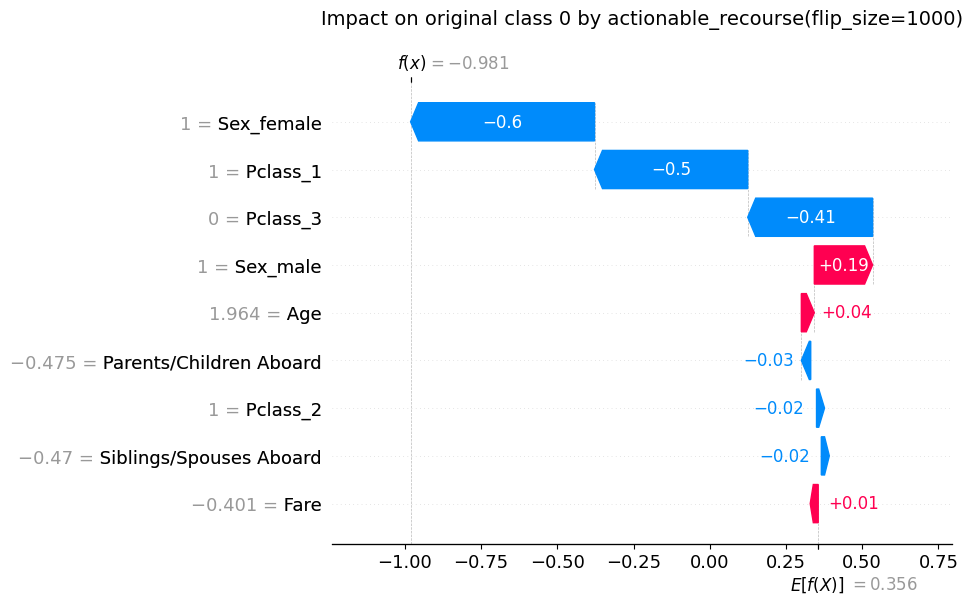

  0%|          | 0/1 [00:00<?, ?it/s]

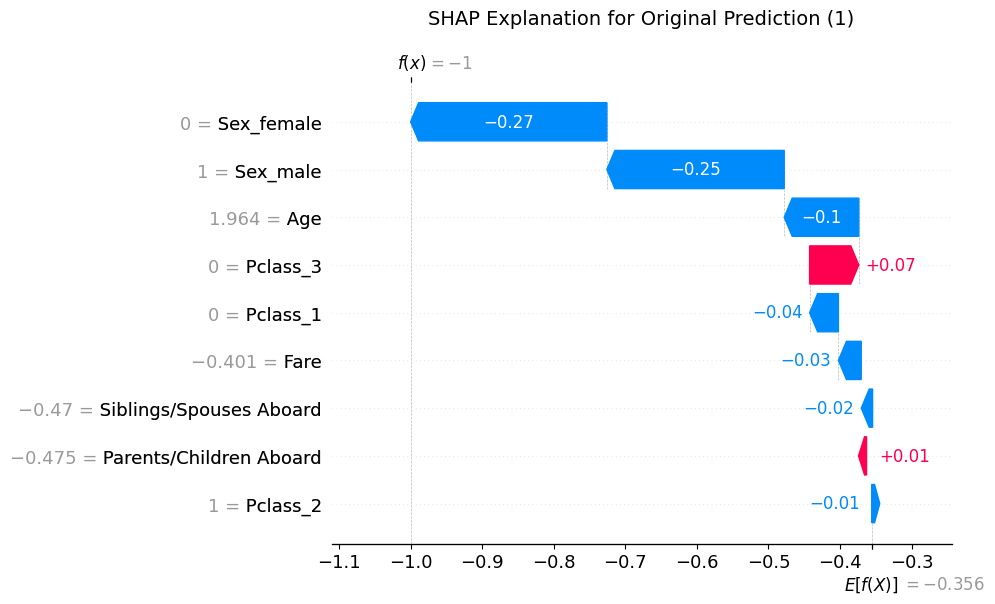

  0%|          | 0/1 [00:00<?, ?it/s]

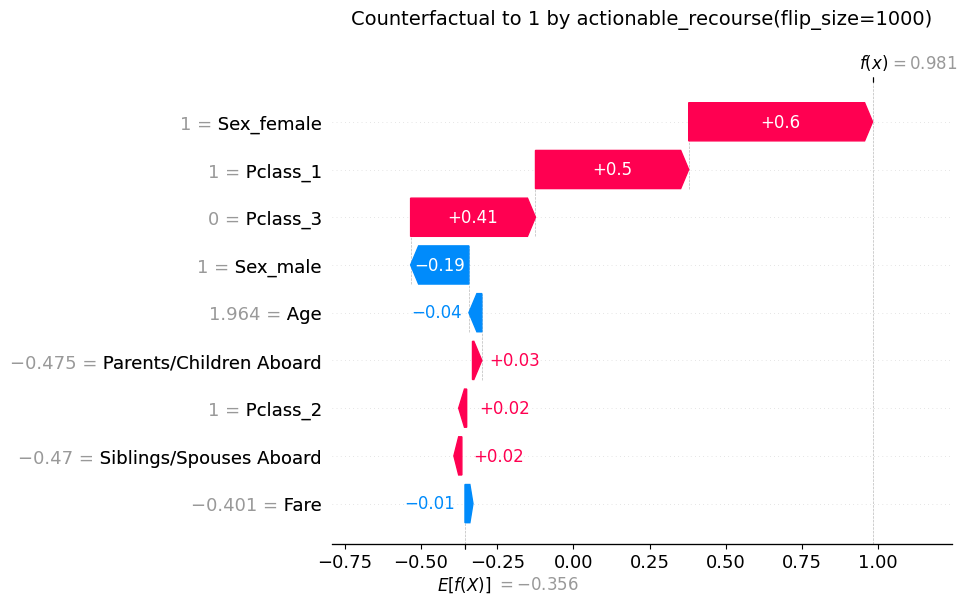

  0%|          | 0/1 [00:00<?, ?it/s]

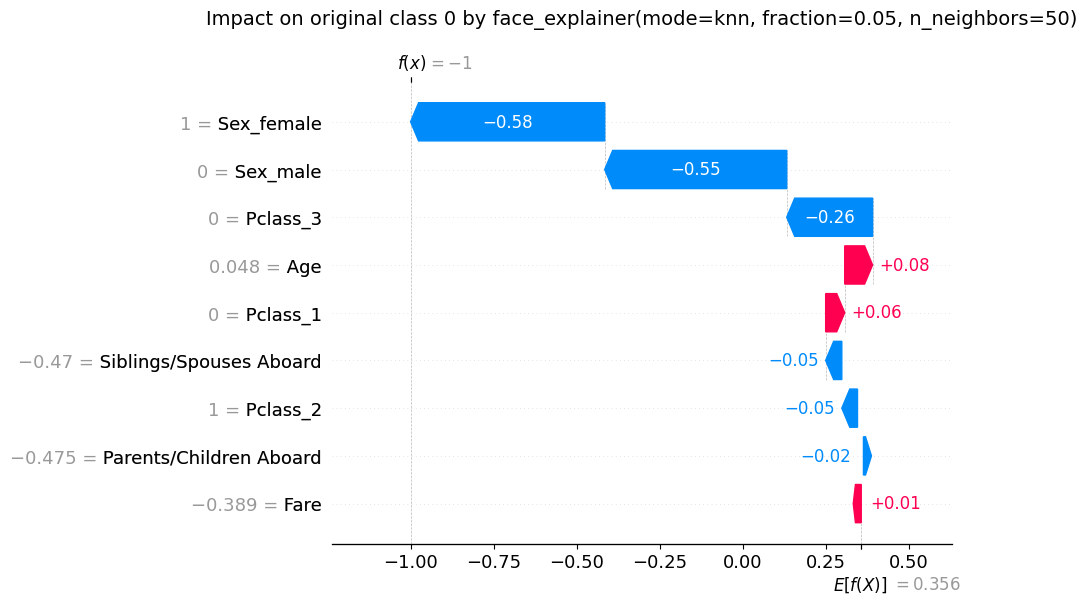

  0%|          | 0/1 [00:00<?, ?it/s]

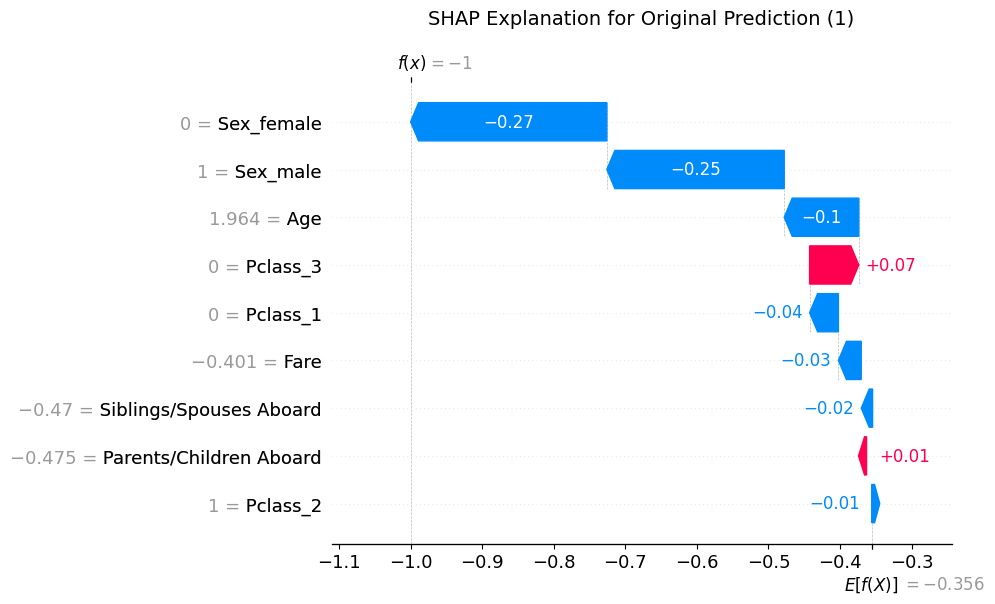

  0%|          | 0/1 [00:00<?, ?it/s]

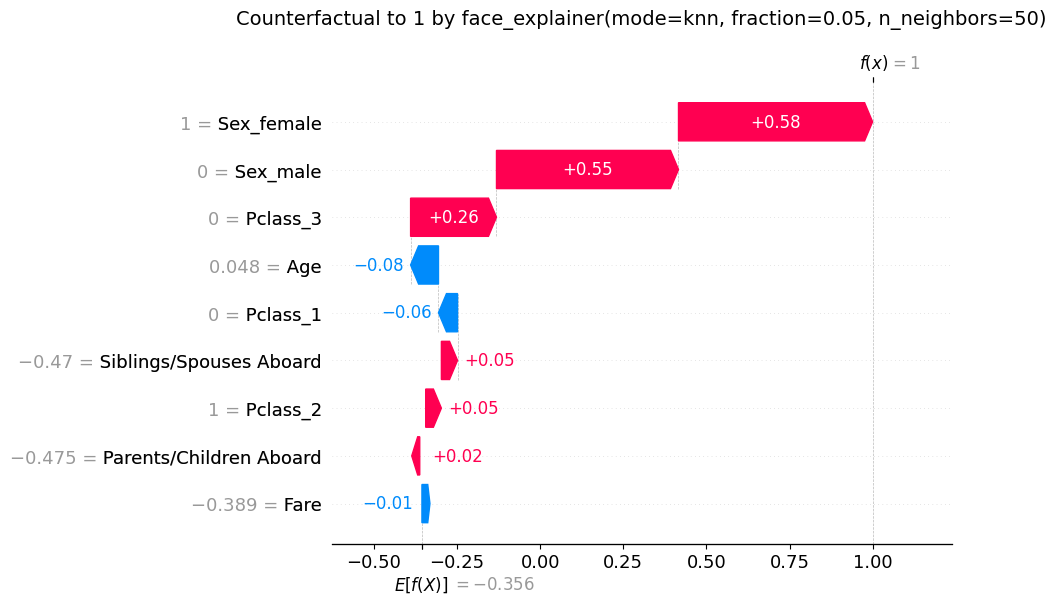

  0%|          | 0/1 [00:00<?, ?it/s]

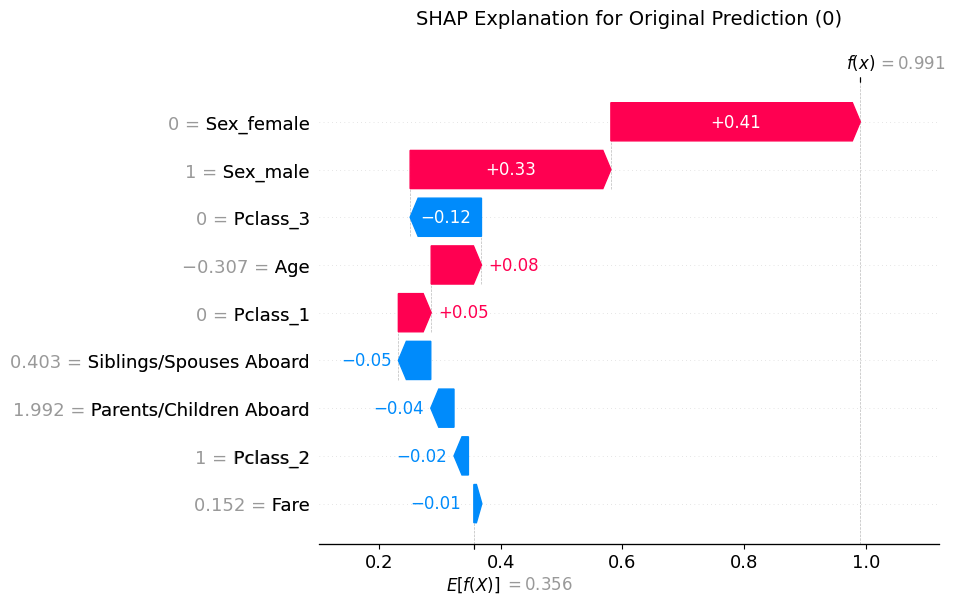

  0%|          | 0/1 [00:00<?, ?it/s]

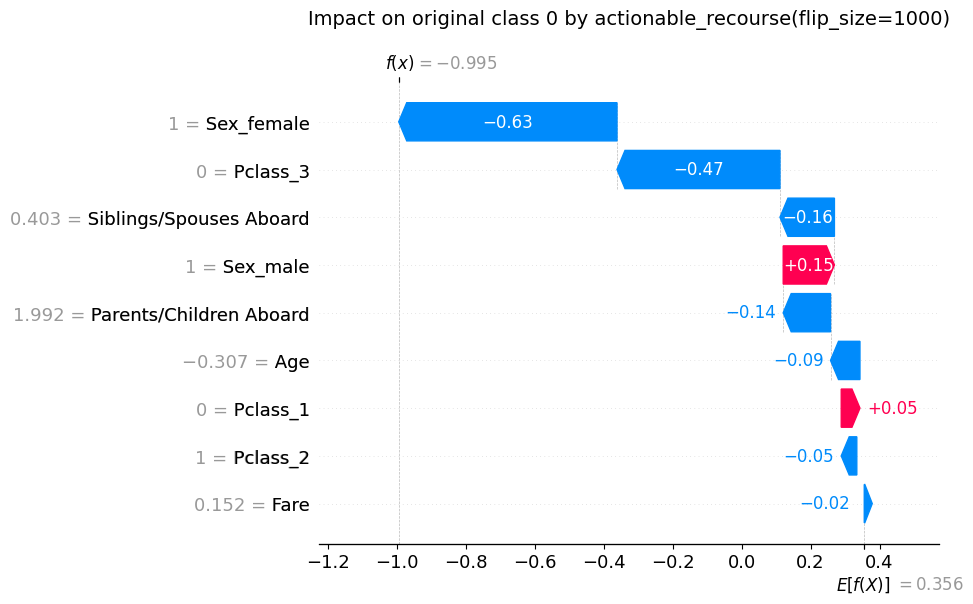

  0%|          | 0/1 [00:00<?, ?it/s]

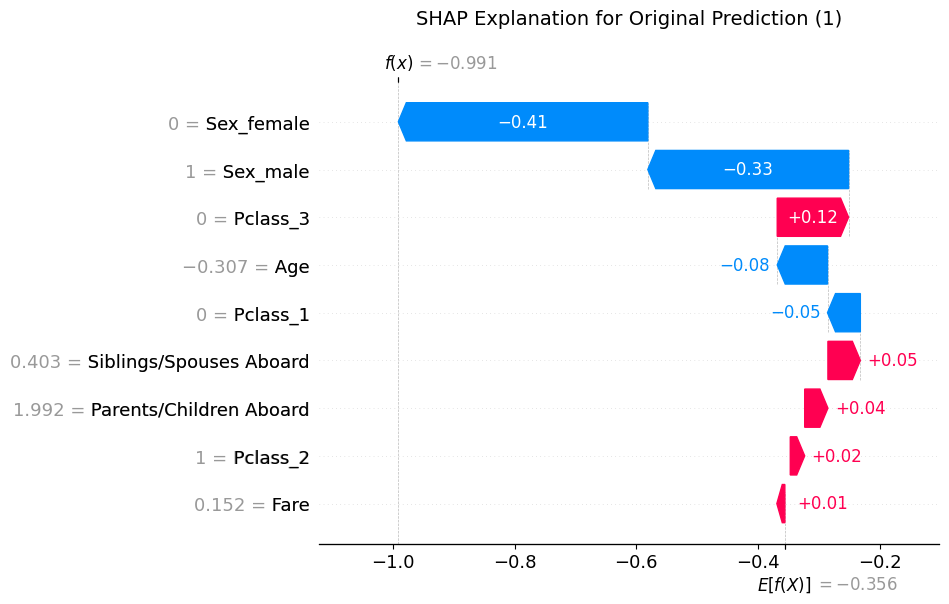

  0%|          | 0/1 [00:00<?, ?it/s]

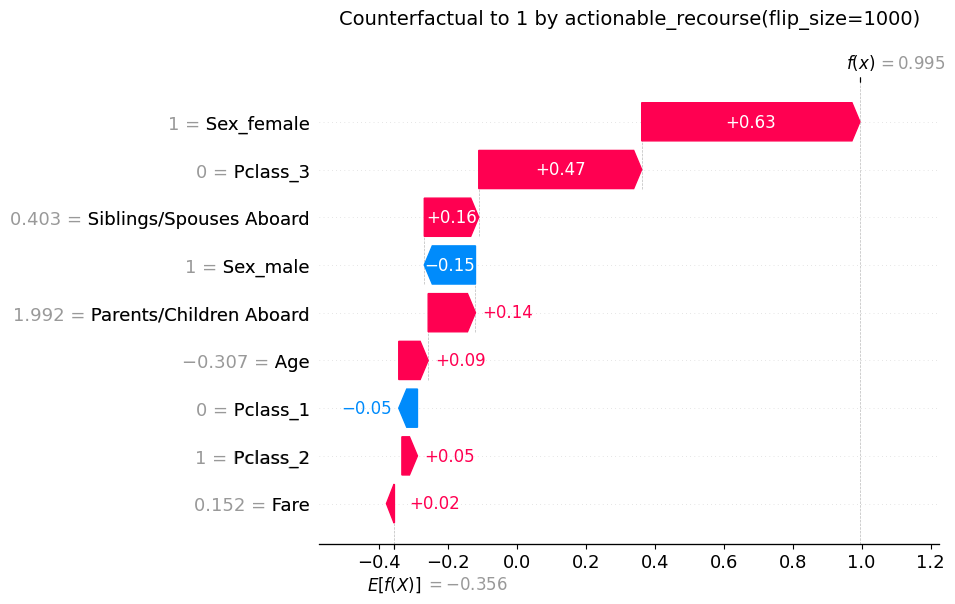

  0%|          | 0/1 [00:00<?, ?it/s]

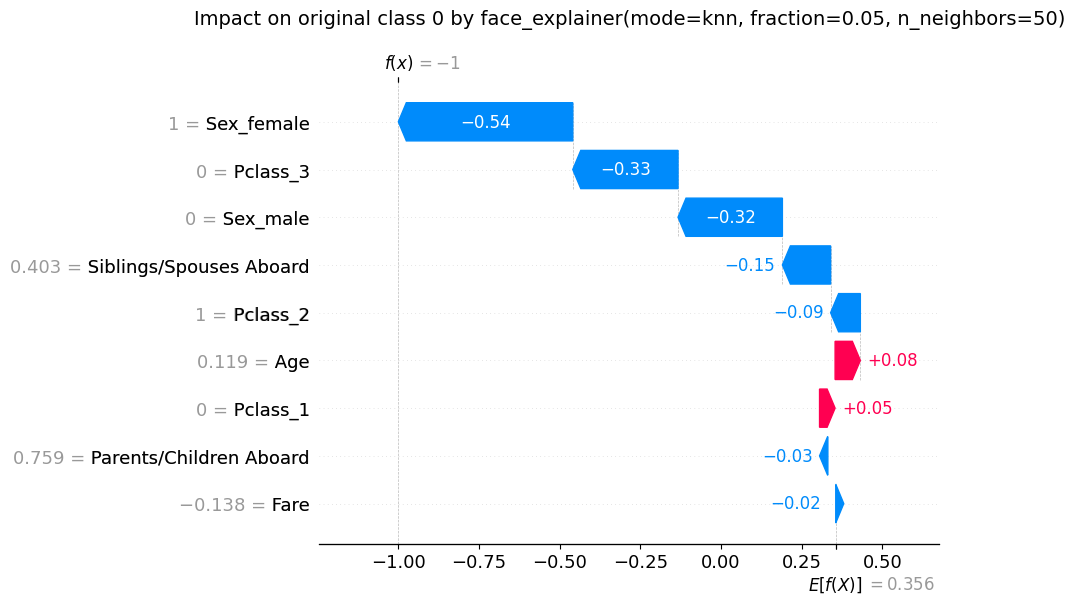

  0%|          | 0/1 [00:00<?, ?it/s]

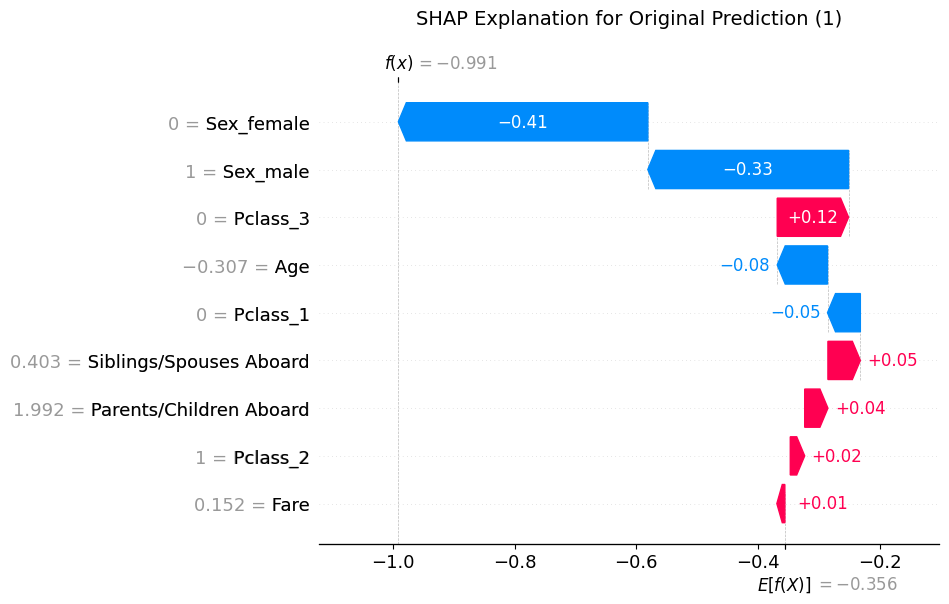

  0%|          | 0/1 [00:00<?, ?it/s]

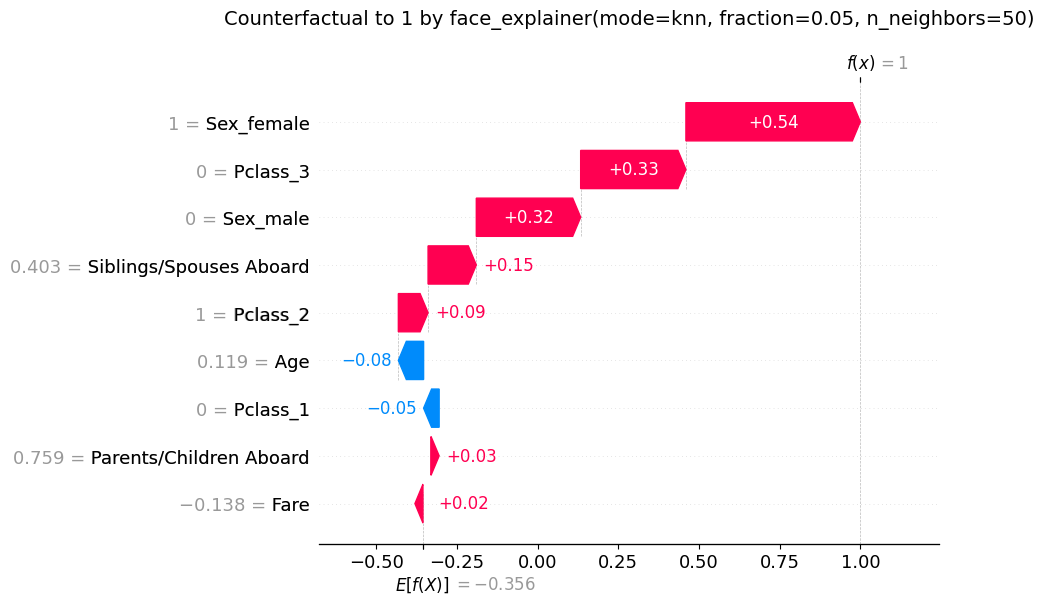

  0%|          | 0/1 [00:00<?, ?it/s]

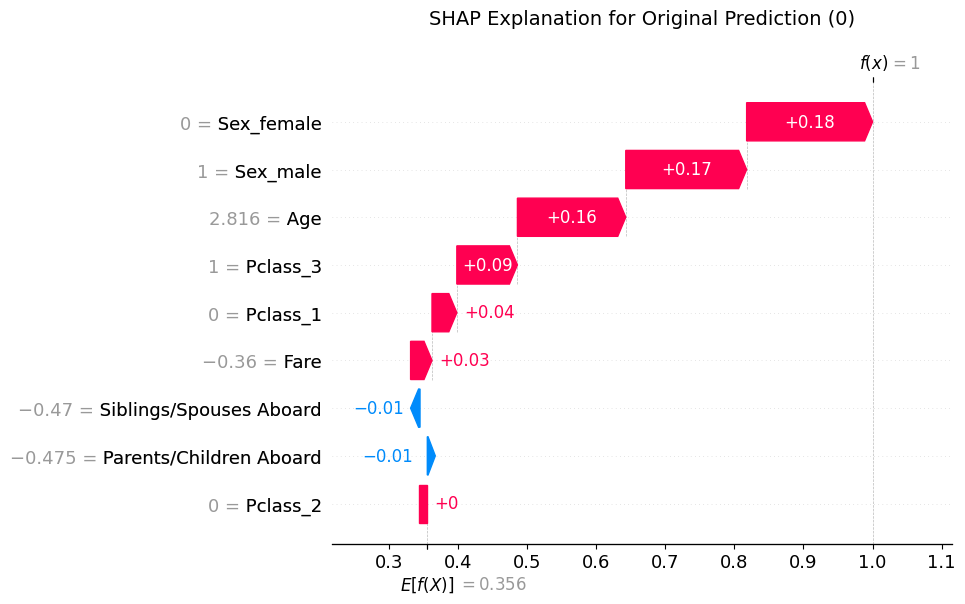

  0%|          | 0/1 [00:00<?, ?it/s]

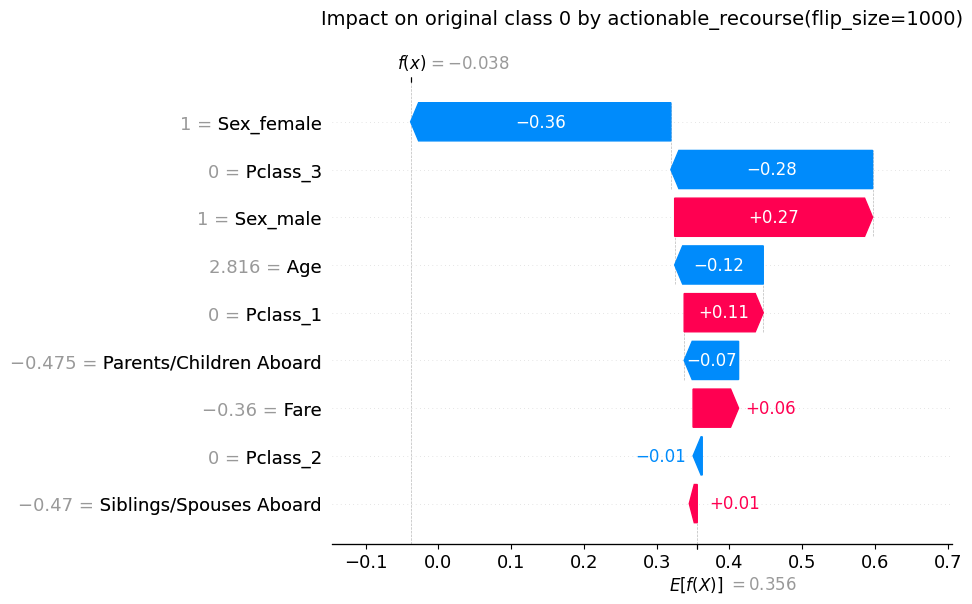

  0%|          | 0/1 [00:00<?, ?it/s]

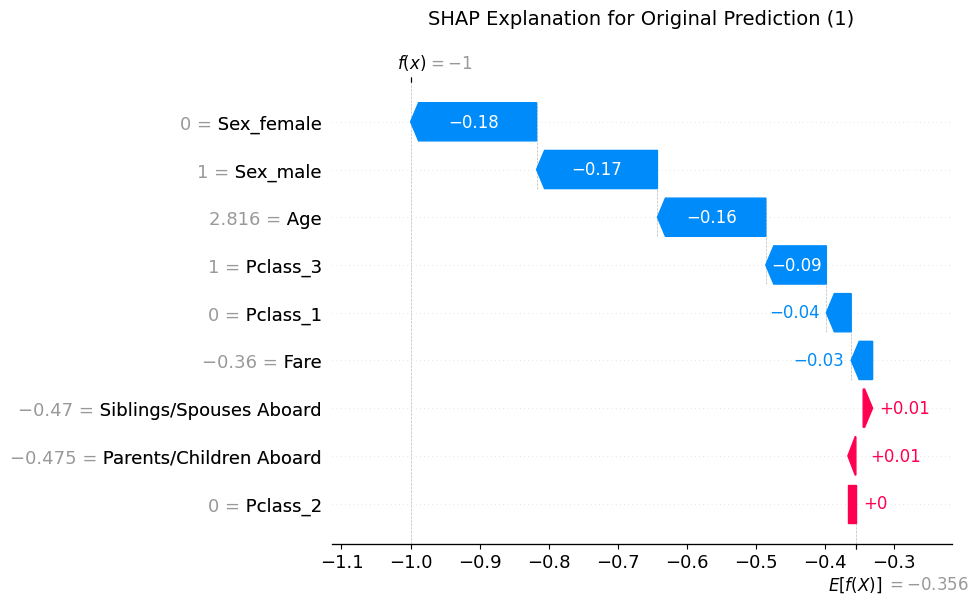

  0%|          | 0/1 [00:00<?, ?it/s]

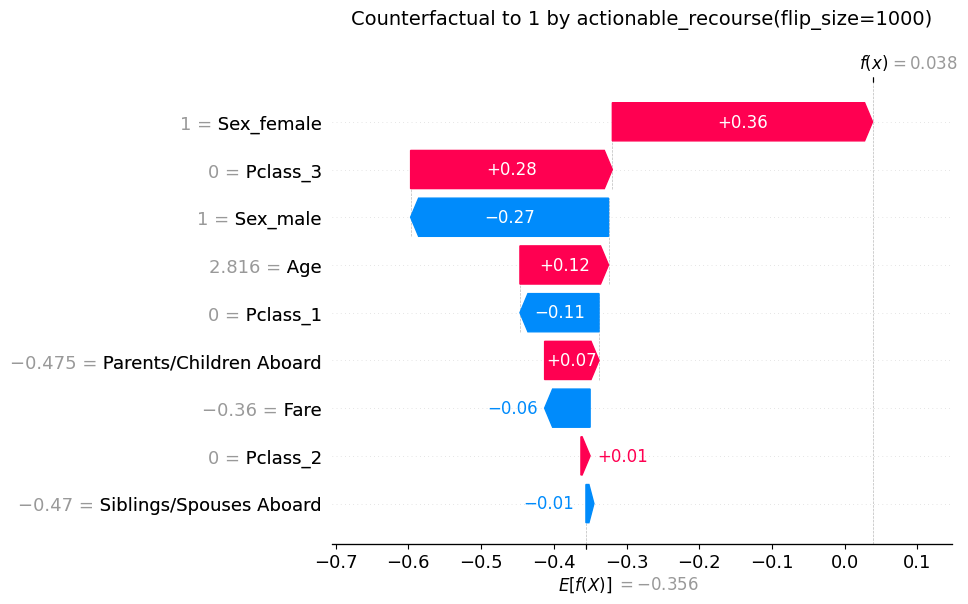

  0%|          | 0/1 [00:00<?, ?it/s]

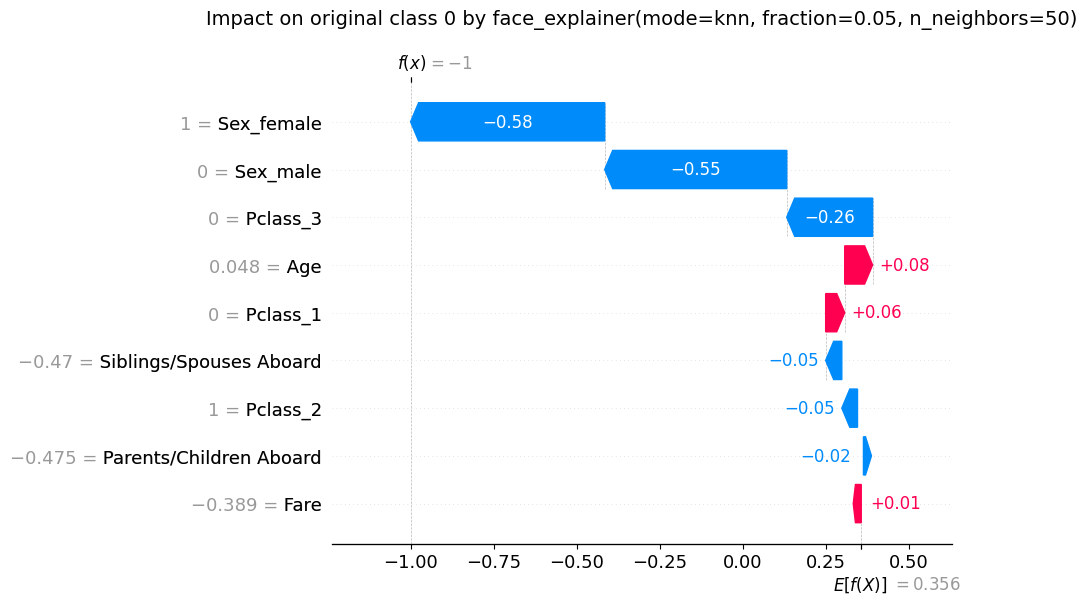

  0%|          | 0/1 [00:00<?, ?it/s]

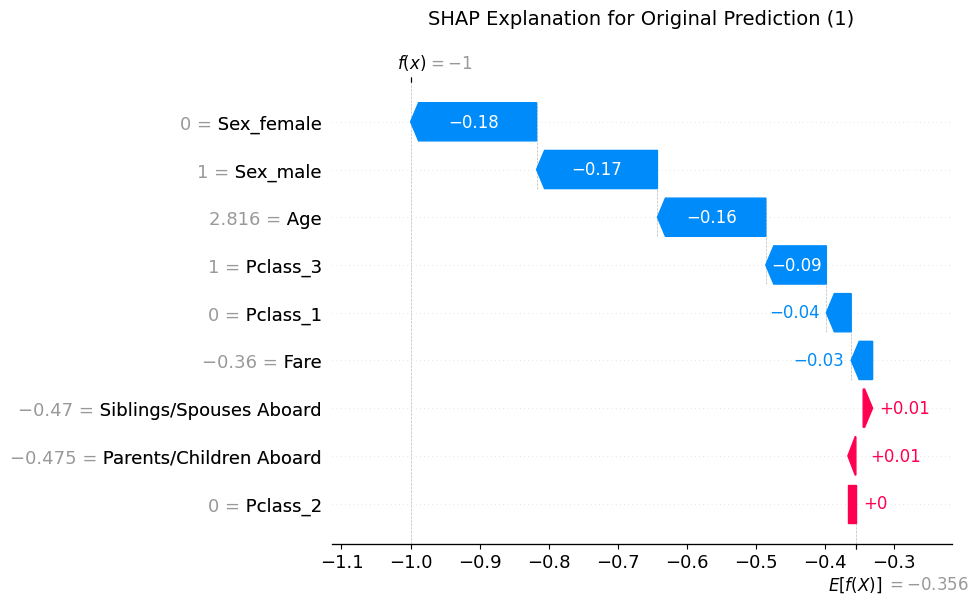

  0%|          | 0/1 [00:00<?, ?it/s]

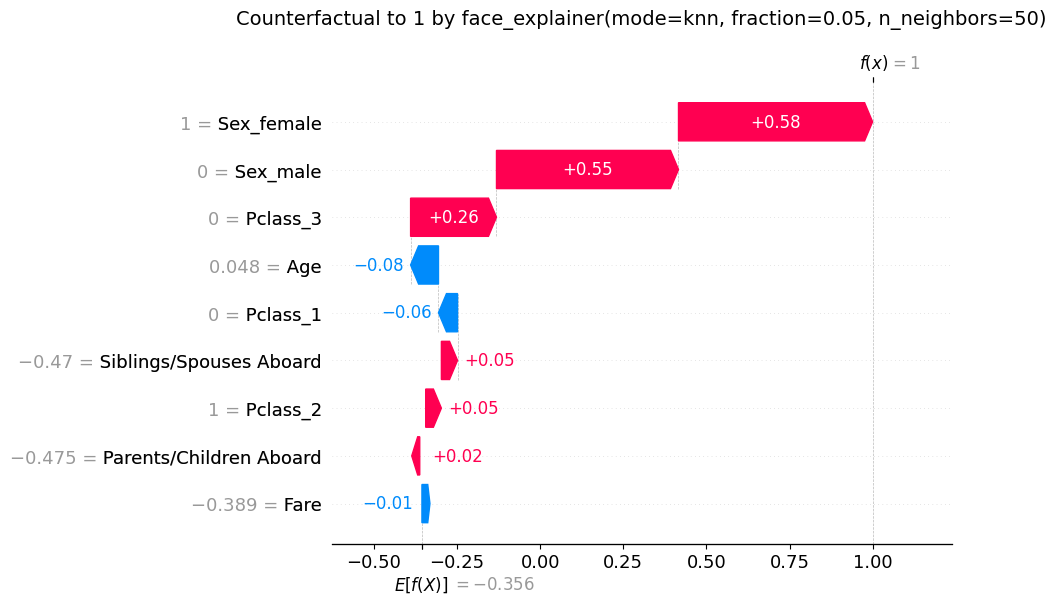

  0%|          | 0/1 [00:00<?, ?it/s]

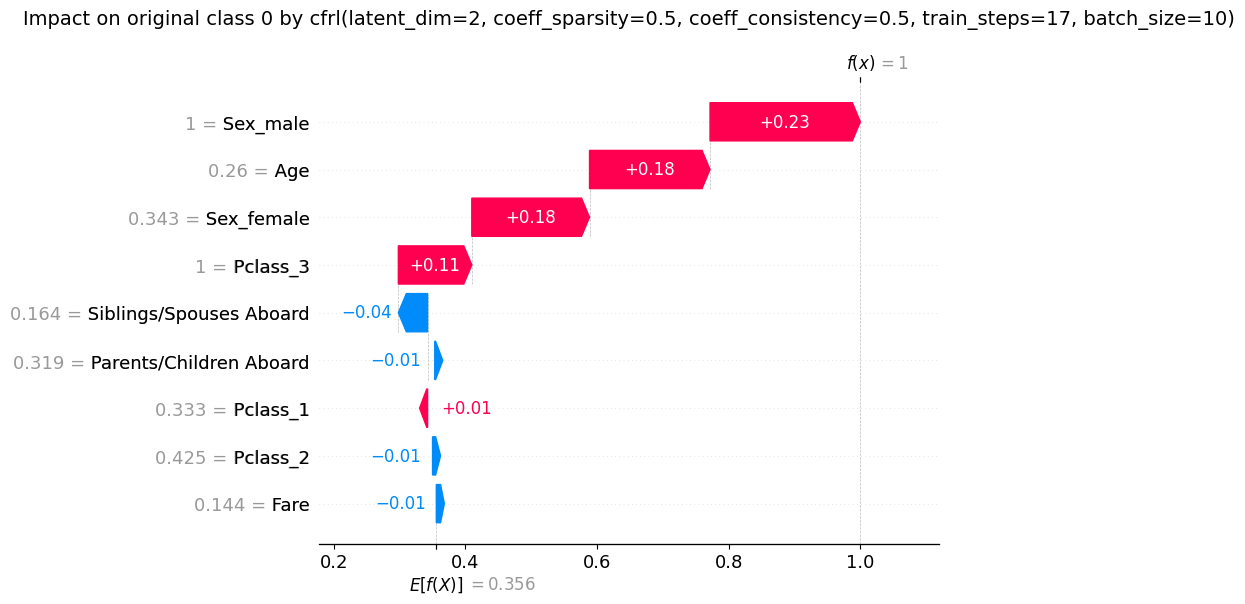

  0%|          | 0/1 [00:00<?, ?it/s]

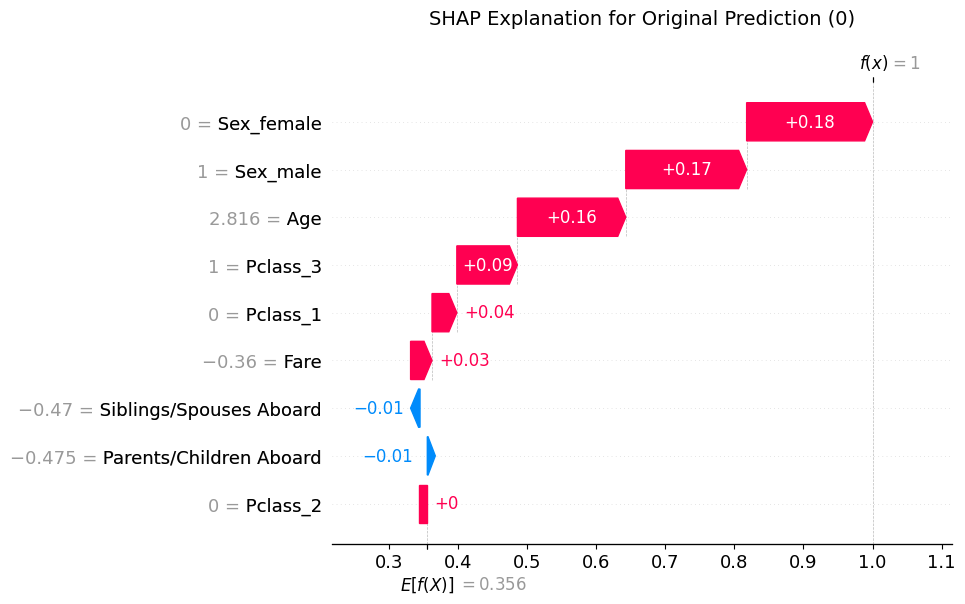

  0%|          | 0/1 [00:00<?, ?it/s]

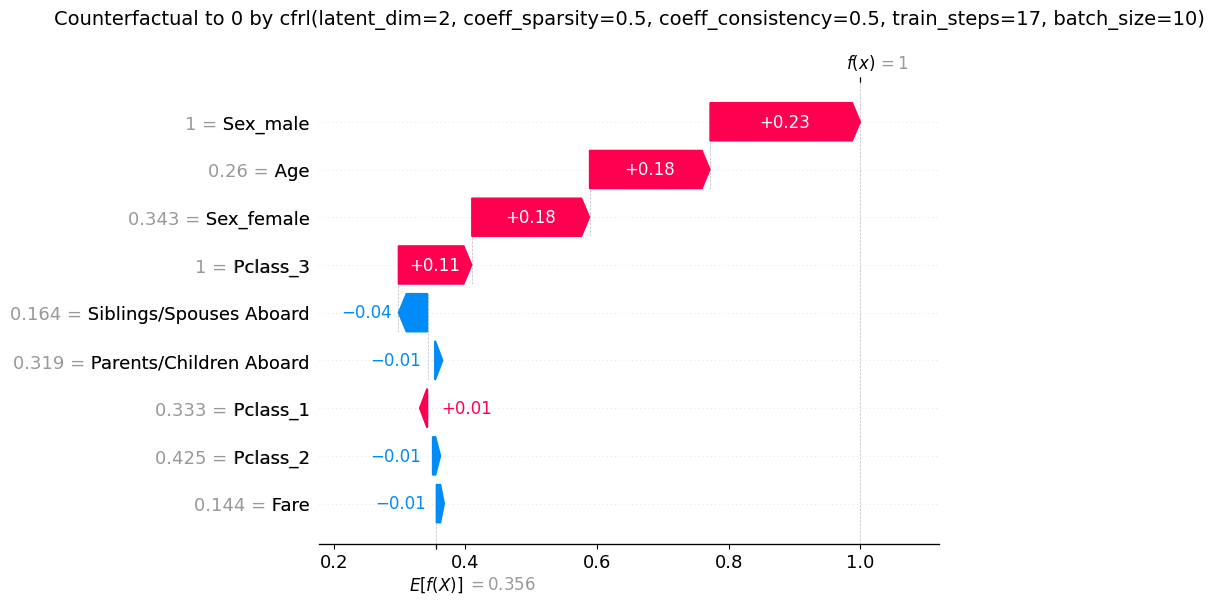

  0%|          | 0/1 [00:00<?, ?it/s]

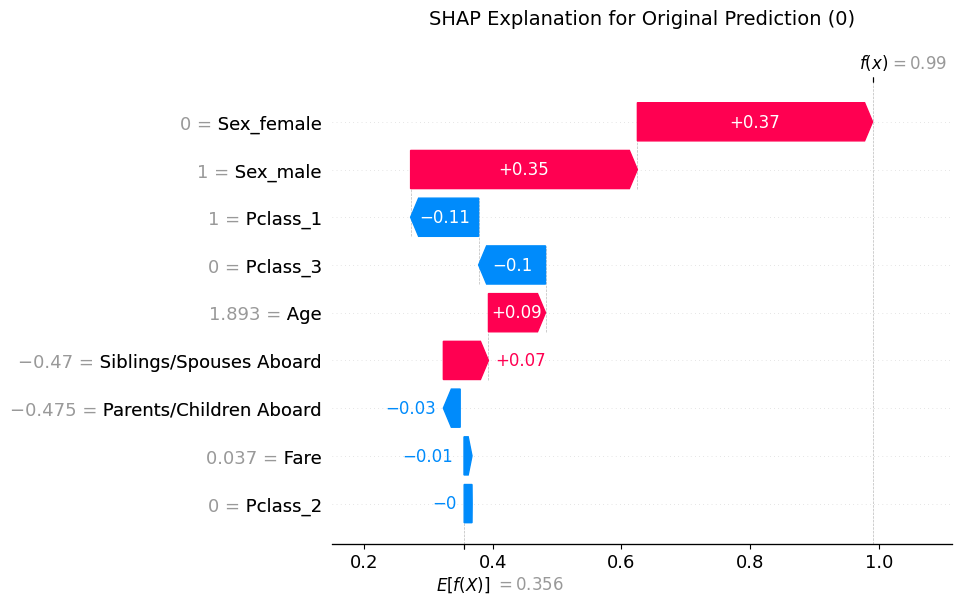

  0%|          | 0/1 [00:00<?, ?it/s]

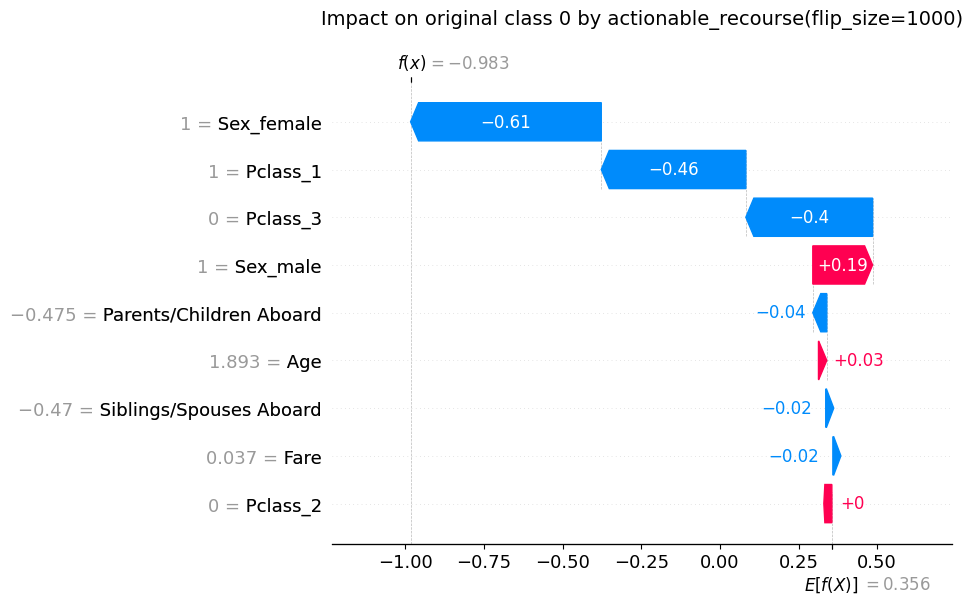

  0%|          | 0/1 [00:00<?, ?it/s]

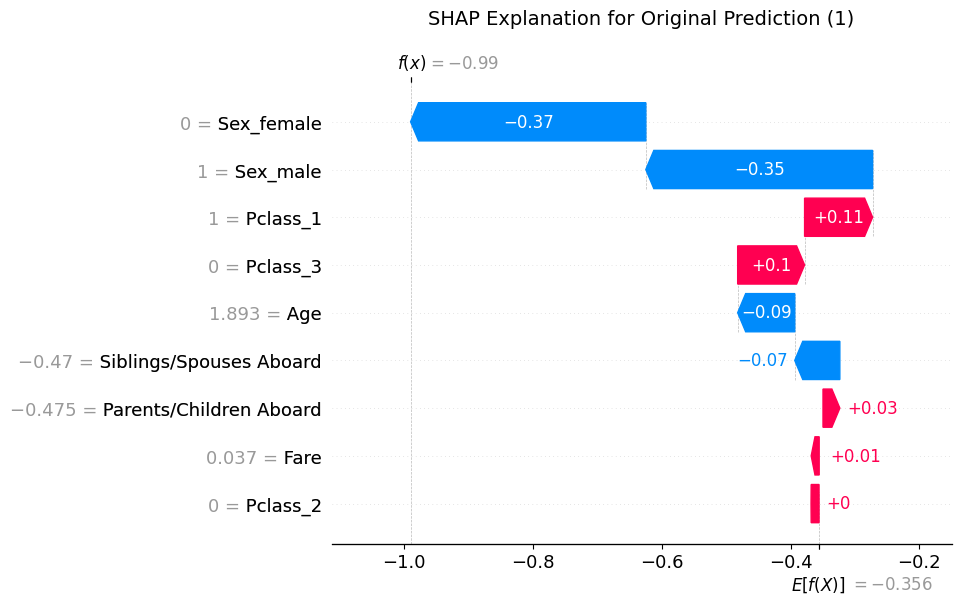

  0%|          | 0/1 [00:00<?, ?it/s]

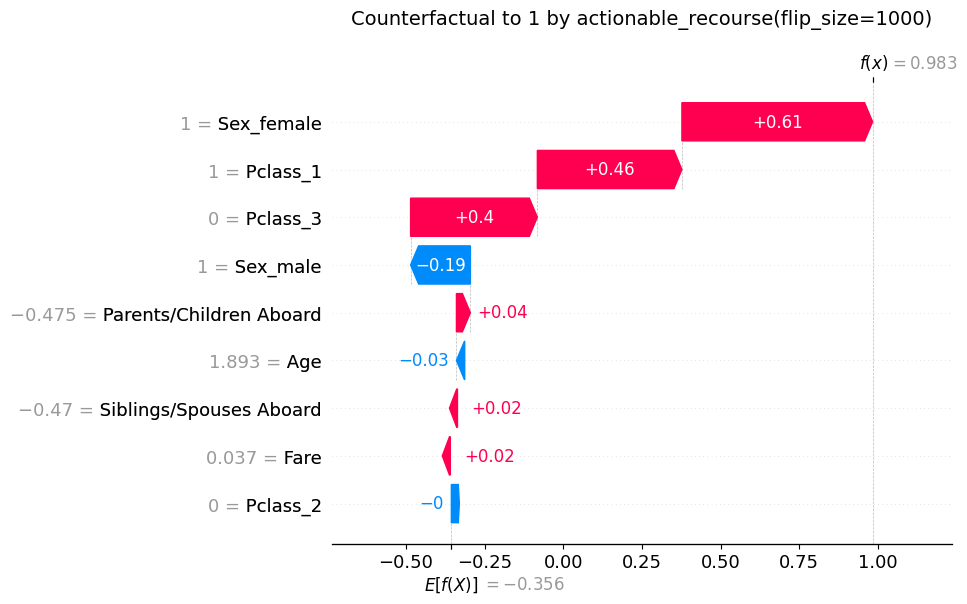

  0%|          | 0/1 [00:00<?, ?it/s]

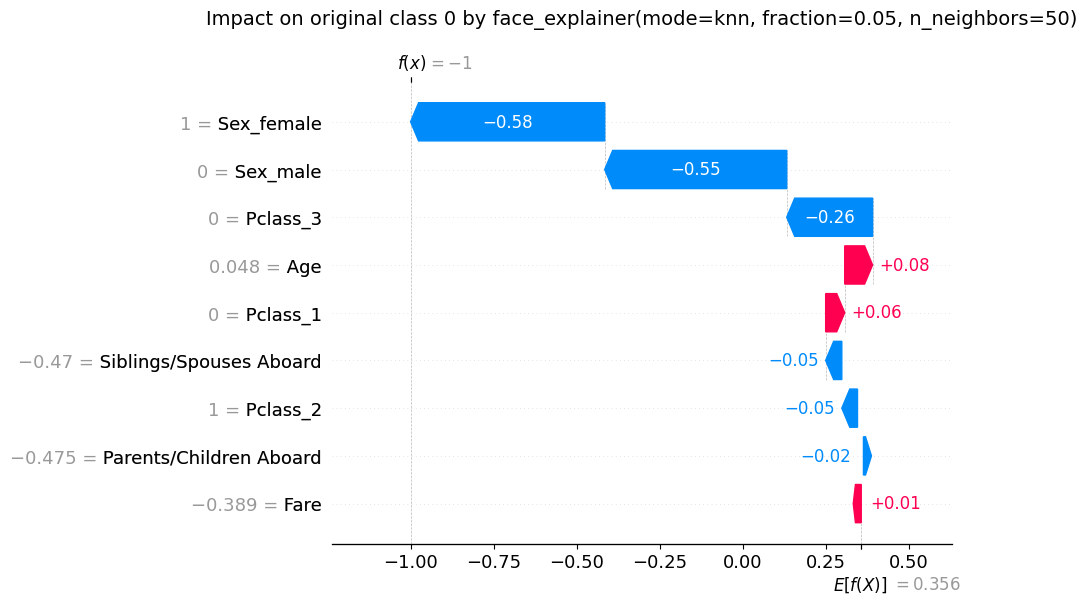

  0%|          | 0/1 [00:00<?, ?it/s]

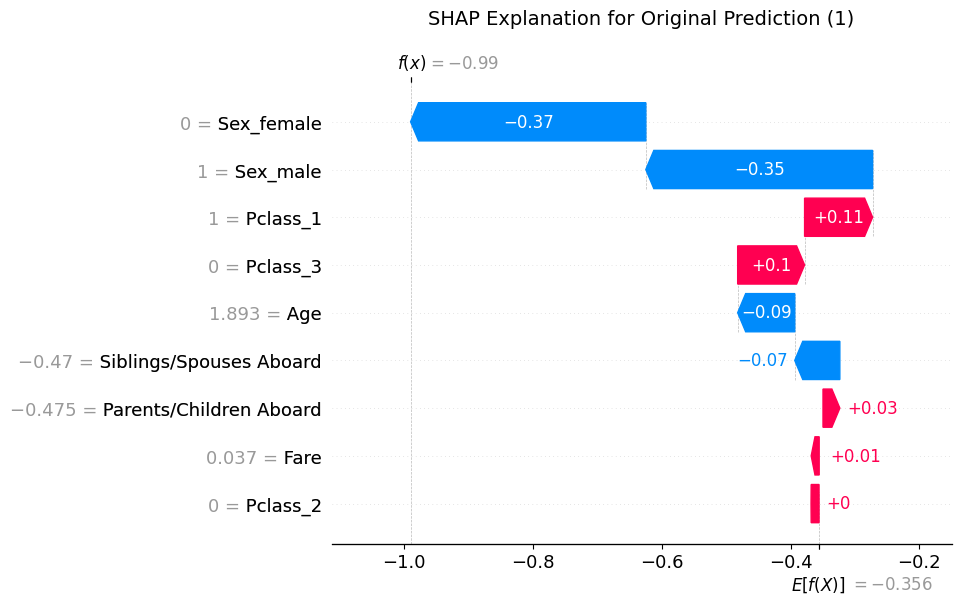

  0%|          | 0/1 [00:00<?, ?it/s]

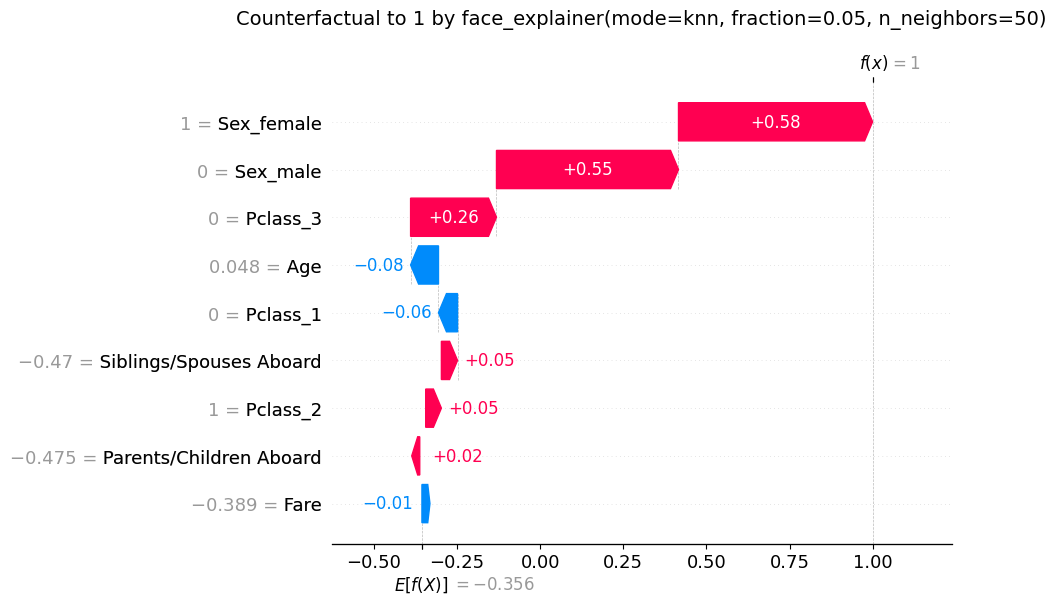

  0%|          | 0/1 [00:00<?, ?it/s]

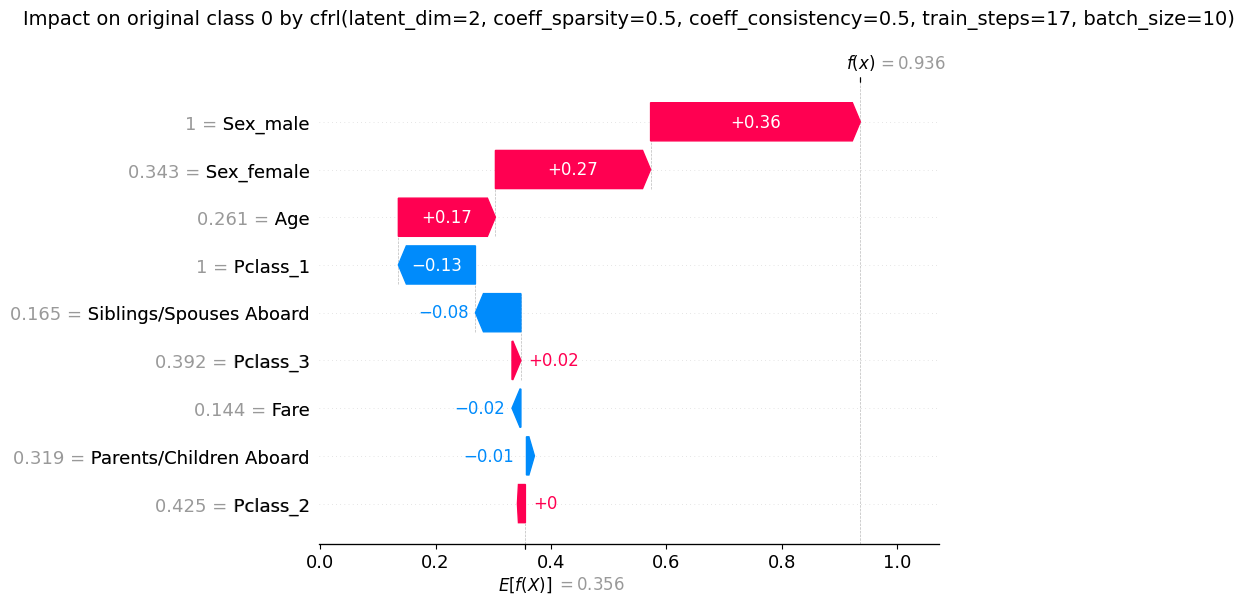

  0%|          | 0/1 [00:00<?, ?it/s]

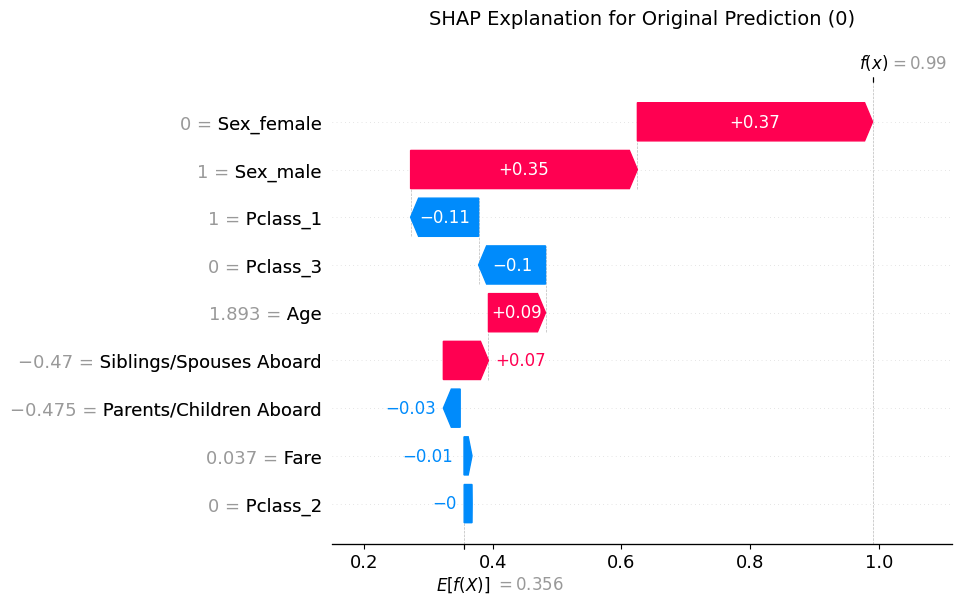

  0%|          | 0/1 [00:00<?, ?it/s]

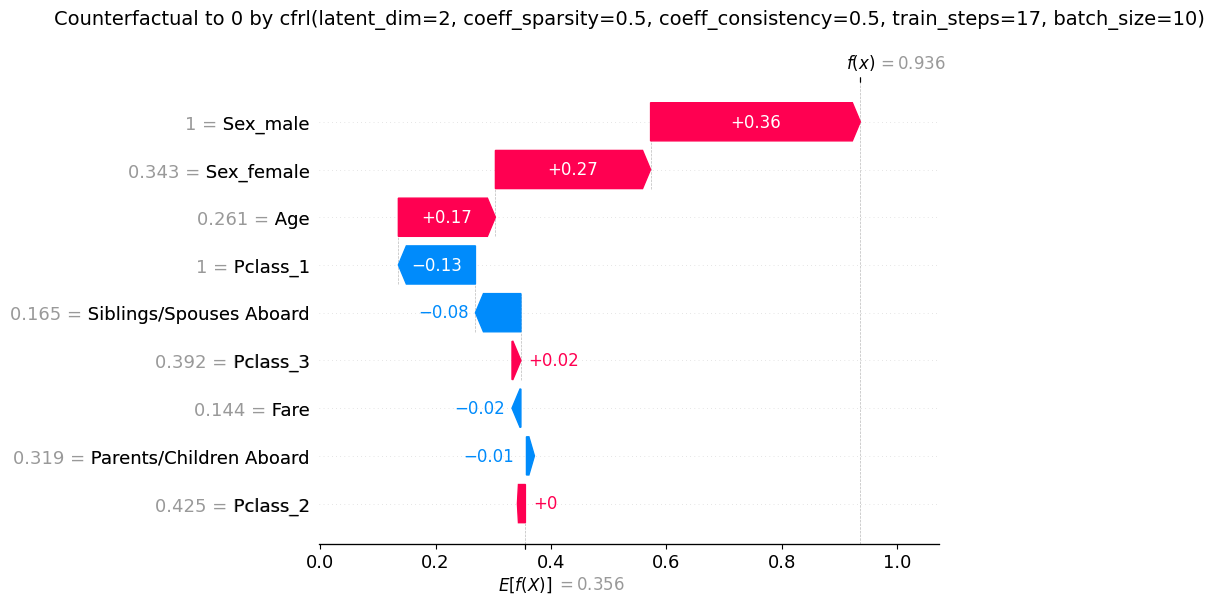

In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt

grouped_cfs = defaultdict(list)
for cf in cfs:
    key = cf.original_data.tobytes()
    grouped_cfs[key].append(cf)

for original_data_bytes, cfs_for_source in grouped_cfs.items():
    original_data = np.frombuffer(original_data_bytes, dtype=np.float64).reshape(1, -1)
    original_class = cfs_for_source[0].original_class

    plt.figure(figsize=(10, 6))
    explainer_orig = explainers[original_class]
    shap_values_orig = explainer_orig.shap_values(original_data)
    
    explanation_orig = shap.Explanation(
        values=shap_values_orig[0],
        base_values=explainer_orig.expected_value,
        data=original_data[0],
        feature_names=feature_names
    )
    plt.title(f"SHAP Explanation for Original Prediction ({original_class})", fontsize=14, pad=20)
    shap.plots.waterfall(explanation_orig, max_display=10, show=True)

    for cf in cfs_for_source:
        plt.figure(figsize=(10, 6))
        x_cf = cf.data.reshape(1, -1)
        target_class = cf.target_class

        explainer_cf = explainers[original_class]
        shap_values_cf = explainer_cf.shap_values(x_cf)

        explanation_cf = shap.Explanation(
            values=shap_values_cf[0],
            base_values=explainer_cf.expected_value,
            data=x_cf[0],
            feature_names=feature_names
        )
        plt.title(f"Impact on original class {original_class} by {cf.explainer}", fontsize=14, pad=20)
        shap.plots.waterfall(explanation_cf, max_display=10, show=True)

        plt.figure(figsize=(10, 6))
        explainer_orig = explainers[target_class]
        shap_values_orig = explainer_orig.shap_values(original_data)
        
        explanation_orig = shap.Explanation(
            values=shap_values_orig[0],
            base_values=explainer_orig.expected_value,
            data=original_data[0],
            feature_names=feature_names
        )
        plt.title(f"SHAP Explanation for Original Prediction ({target_class})", fontsize=14, pad=20)
        shap.plots.waterfall(explanation_orig, max_display=10, show=True)

        plt.figure(figsize=(10, 6))
        x_cf = cf.data.reshape(1, -1)
        target_class = cf.target_class

        explainer_cf = explainers[target_class]
        shap_values_cf = explainer_cf.shap_values(x_cf)

        explanation_cf = shap.Explanation(
            values=shap_values_cf[0],
            base_values=explainer_cf.expected_value,
            data=x_cf[0],
            feature_names=feature_names
        )
        plt.title(f"Counterfactual to {target_class} by {cf.explainer}", fontsize=14, pad=20)
        shap.plots.waterfall(explanation_cf, max_display=10, show=True)
